#  Projet Machine Learning  
## Prédiction d’éligibilité à un prêt (Loan Prediction)

**Auteurs :** Mohammed Lahjaji  

Ce projet a pour objectif de prédire l’approbation d’un prêt bancaire
à partir de caractéristiques socio-économiques des emprunteurs.
Nous utilisons des méthodes supervisées et non supervisées, en suivant une
démarche complète : EDA, prétraitement, modélisation, interprétation
et analyse PCA.


## 0. Installation / environnement

In [34]:
# ============================================
# 0. Imports + chargement
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer




## 1. Chargement des données


### 2.1 Aperçu général du dataset


In [35]:
sns.set(style="whitegrid")

df = pd.read_csv("Train_Loan_Home.csv")

# ============================================
# 1. Aperçu général
# ============================================
print("Shape :", df.shape)

Shape : (614, 13)


Le dataset contient 614 observations et 13 variables, ce qui est suffisant pour entraîner plusieurs modèles de classification.

In [36]:
print(df.head())
print(df.info())


    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

On observe 8 colonnes catégorielles et 5 colonnes numériques. Cela montre qu'un encodage sera nécessaire avant la modélisation.\nDe plus, la variable cible est catégorielle ('Y'/'N')

In [37]:
print(df.describe())
print(df.describe(include='object'))


       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  
         Loan_ID Gender Married Dependents Education Self_Employed  \
count        614    601     611       

D'après les statistiques descriptives ci-dessus, on remarque que :
- ApplicantIncome présente une forte variabilité (min=150, max=81000), ce qui indique des outliers et une distribution probablement asymétrique.
- CoapplicantIncome présente aussi une forte variabilité, ce qui indique des outliers et une distribution probablement asymétrique.
- LoanAmount contient également une dispersion importante (entre 9 et 700).
- Credit_History est une variable binaire très déséquilibrée (84 % de '1'), ce qui peut influencer fortement le modèle.
- Le dataset comporte beaucoup plus d’hommes (489) que de femmes (112 non-nuls).
- La plupart des emprunteurs sont 'Graduate' (480 sur 614), et ne sont pas 'Self_Emplyed' (500 sur 582 non-nuls).
- La variable cible est déséquilibrée : 422 'Y' vs 192 'N'.

### 2.2 Valeurs manquantes



Valeurs manquantes :
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


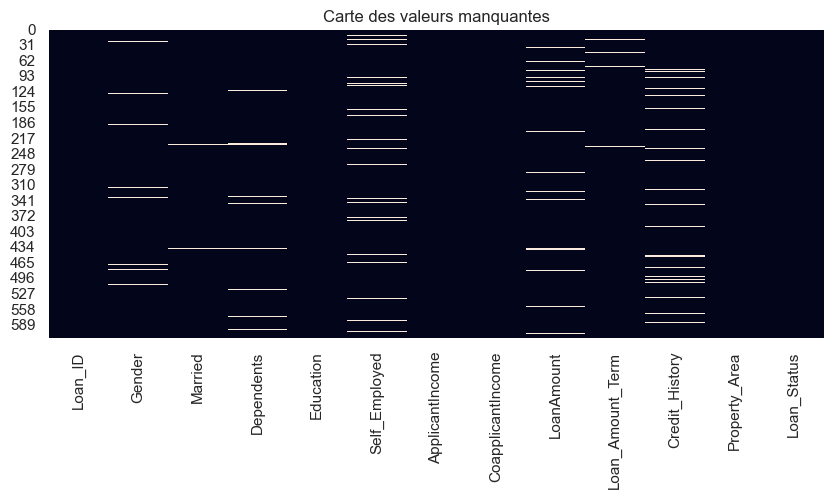

In [38]:
# ============================================
# 2. Valeurs manquantes
# ============================================
print("\nValeurs manquantes :")
print(df.isna().sum())

plt.figure(figsize=(10,4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Carte des valeurs manquantes")
plt.show()



Certaines colonnes présentent un nombre significatif de valeurs manquantes. Ainsi, il appliquer une bonne stratégie pour imputer ces valeurs manquantes.

### 2.3 Distribution des variables numériques


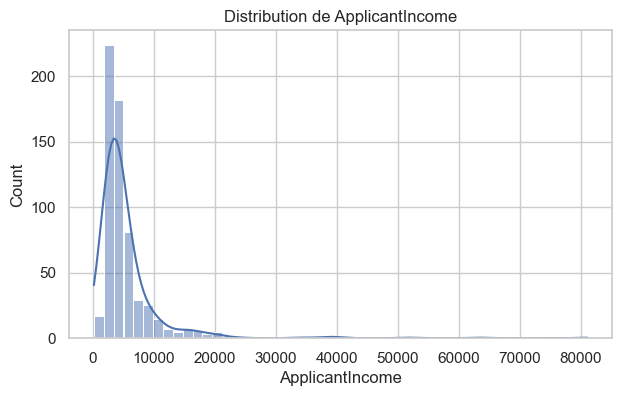

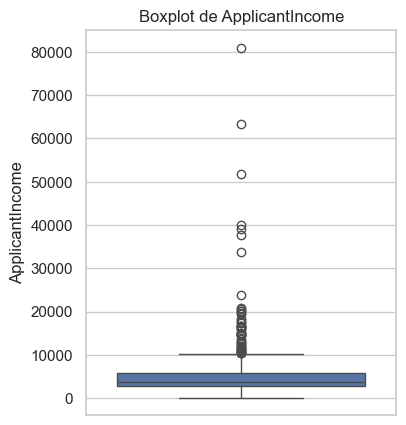

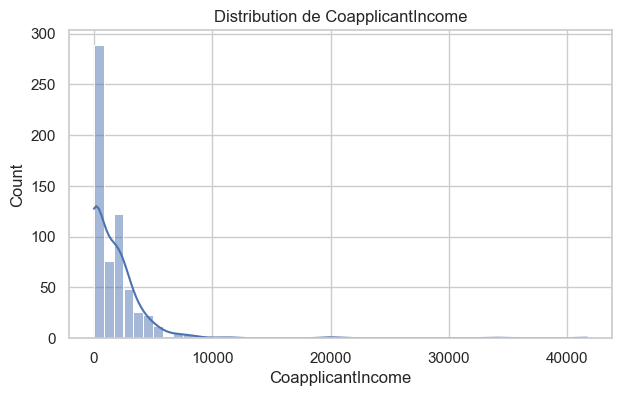

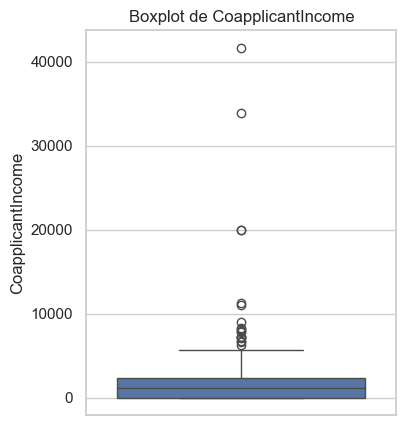

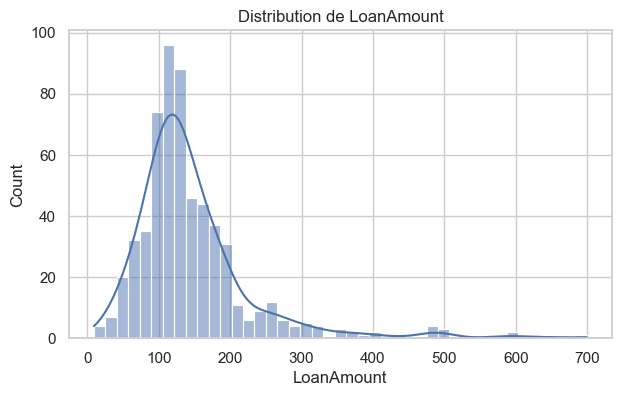

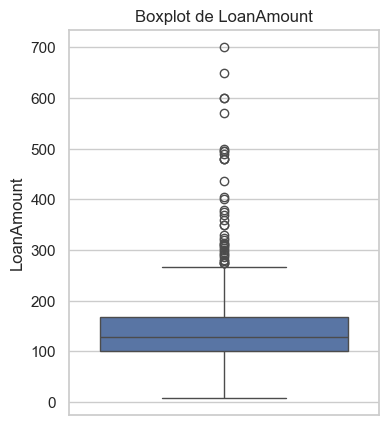

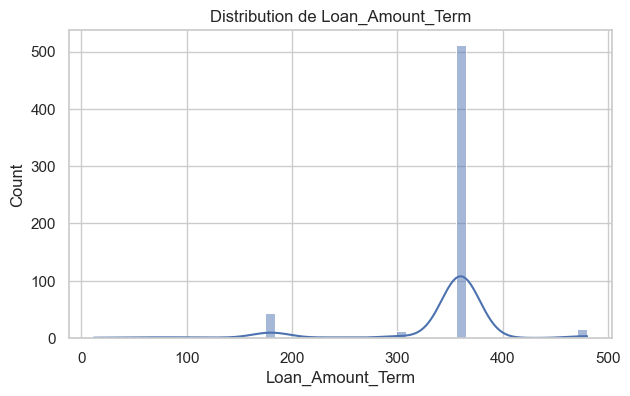

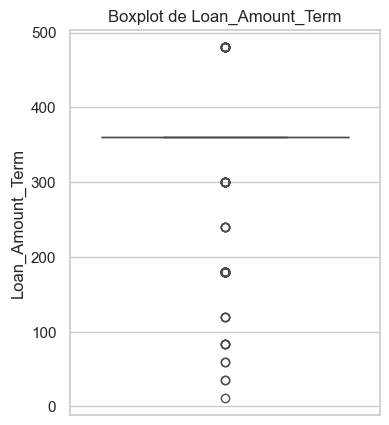

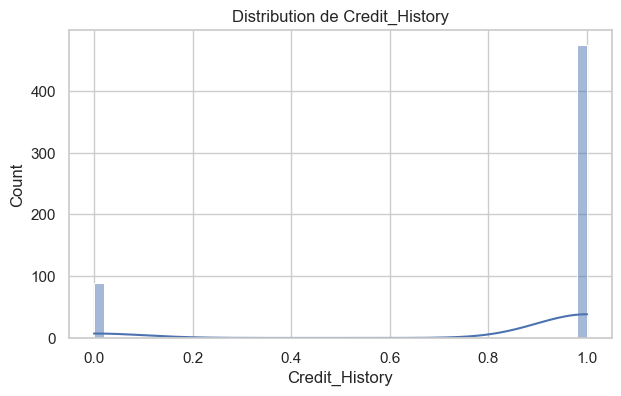

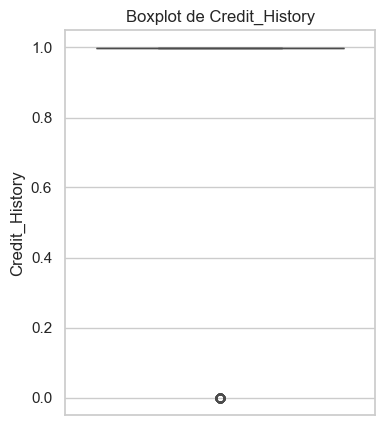

In [39]:
# ============================================
# 3. Colonnes numériques / catégorielles
# ============================================
numeric_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount",
                "Loan_Amount_Term", "Credit_History"]

categorical_cols = ["Gender", "Married", "Dependents", "Education",
                    "Self_Employed", "Property_Area"]

target_col = "Loan_Status"
    

# ============================================
# 4. Distributions des variables numériques
# ============================================
for col in numeric_cols:
    plt.figure(figsize=(7,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution de {col}")
    plt.show()

    plt.figure(figsize=(4,5))
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()



Les variables numériques présentent globalement une forte asymétrie à droite, avec plusieurs outliers d’ampleur économiquement réaliste.\
ApplicantIncome, CoapplicantIncome et LoanAmount montrent une variabilité importante, ce qui justifiera une standardisation dans le pipeline de preprocessing.\
Loan_Amount_Term est très concentrée autour de 360, tandis que Credit_History est une variable binaire particulièrement déséquilibrée.

### 2.4 Variables catégorielles et cible Loan_Status


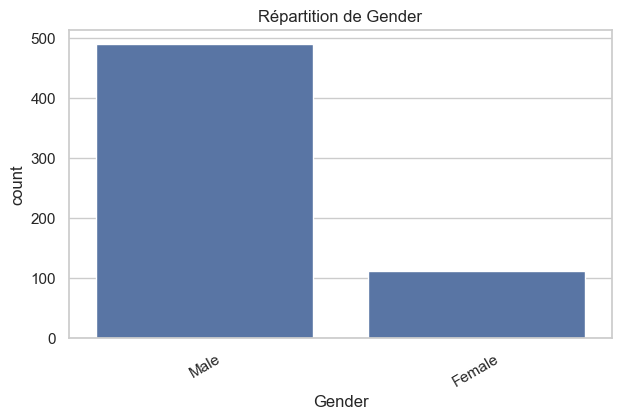

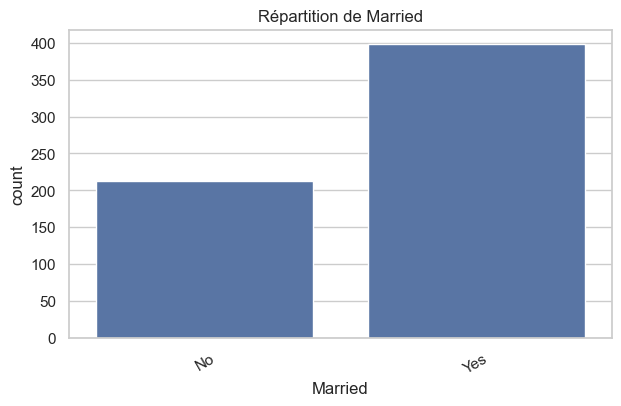

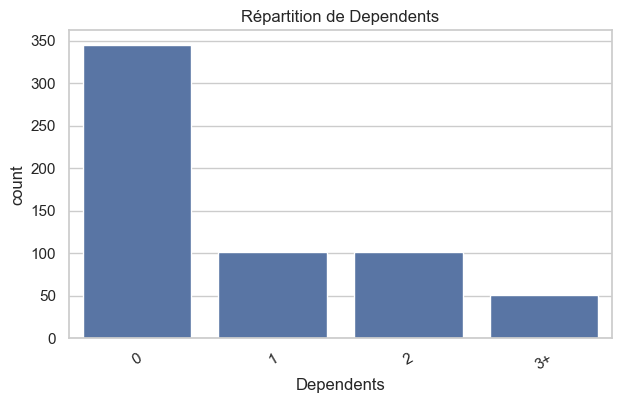

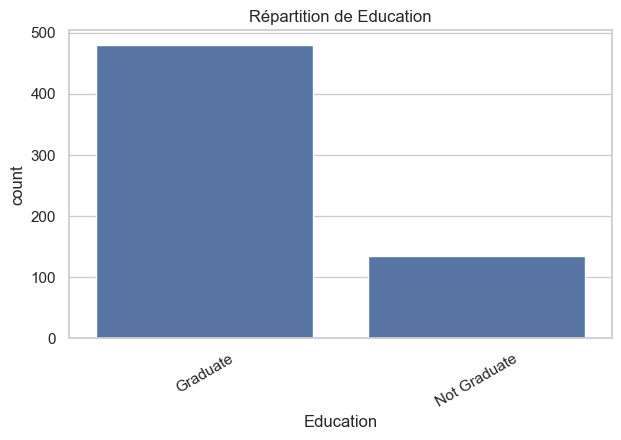

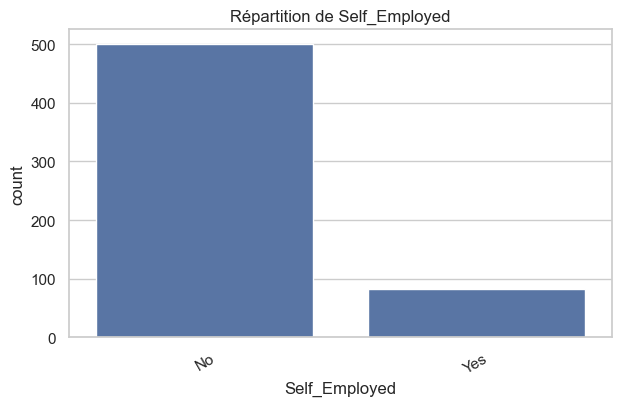

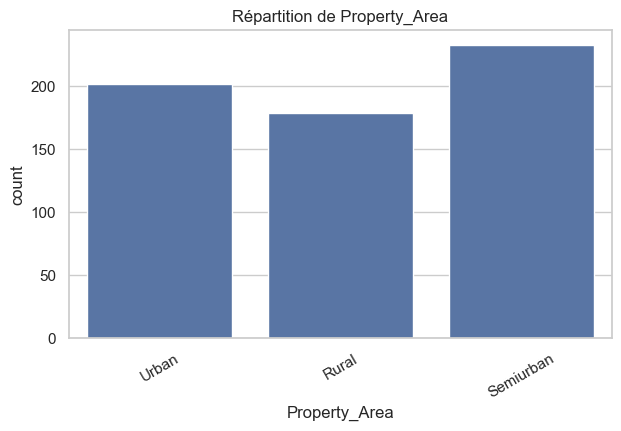

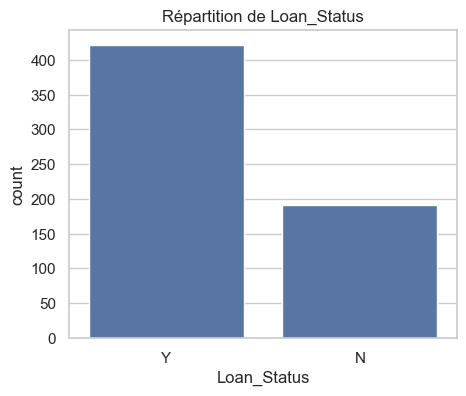


Proportions de Loan_Status :
Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64


In [40]:
# ============================================
# 5. Distributions des variables catégorielles
# ============================================
for col in categorical_cols:
    plt.figure(figsize=(7,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Répartition de {col}")
    plt.xticks(rotation=30)
    plt.show()

# ============================================
# 6. Distribution de la cible Loan_Status
# ============================================
plt.figure(figsize=(5,4))
sns.countplot(data=df, x=target_col)
plt.title("Répartition de Loan_Status")
plt.show()

print("\nProportions de Loan_Status :")
print(df[target_col].value_counts(normalize=True))



D'après les graphiques ci-dessus, plusieurs commentaires peuvent être soulignés:
- La variable Gender est fortement déséquilibrée : environ 80 % des emprunteurs sont des hommes, contre environ 20 % de femmes. Cette distribution peut refléter un biais structurel dans la population de demandeurs de prêt.
- La majorité des emprunteurs sont mariés (~65 %), alors que ~35 % ne le sont pas. Cela suggère que la variable Married pourrait être informative.
- La catégorie la plus représentée est 0 dépendant (environ 345 cas), suivie de 1, 2, puis 3+ dépendants. La distribution est raisonnablement variée et ne nécessite pas de regroupement.
- La majorité des emprunteurs sont diplômés (Graduate), ce qui reflète potentiellement une population à revenu moyen/élevé. Les non-graduates représentent environ 20 % des cas.
- La majorité écrasante des emprunteurs ne sont pas travailleurs indépendants (environ 500 No contre ~80 Yes). La rareté de la catégorie Yes n’est pas problématique, mais elle peut limiter la capacité du modèle à apprendre un pattern robuste pour cette sous-population.
- Les zones Urban, Rural et Semiurban sont globalement équilibrées, avec un léger avantage à Semiurban. Cette variable est bien distribuée et convient bien à un encodage One-Hot.
- La variable cible est déséquilibrée : environ 69 % de prêts approuvés (Y) contre 31 % de prêts refusés (N). Ainsi, ce déséquilibre devra être pris en compte lors de l’évaluation du modèle.

### 2.5 Relation entre Credit_History et Loan_Status


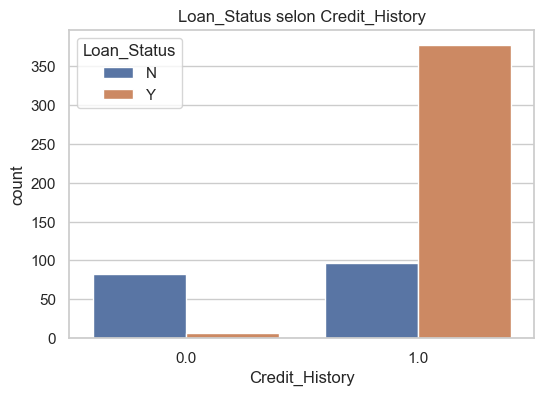


Table croisée Credit_History / Loan_Status :
Loan_Status            N         Y
Credit_History                    
0.0             0.921348  0.078652
1.0             0.204211  0.795789


In [41]:
# ============================================
# 7. Relation Credit_History vs Loan_Status
# (SUPER IMPORTANT dans ce dataset)
# ============================================
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Credit_History", hue=target_col)
plt.title("Loan_Status selon Credit_History")
plt.show()

print("\nTable croisée Credit_History / Loan_Status :")
print(pd.crosstab(df["Credit_History"], df[target_col], normalize="index"))



La relation entre Loan_Status et Credit_History est extrêmement forte : près de 80 % des emprunteurs ayant un historique positif obtiennent un prêt, tandis que plus de 90 % des emprunteurs sans historique voient leur demande refusée. Ainsi, on constate que Credit_History est de loin la variable la plus importante pour prédire l’approbation d’un prêt. Elle sépare presque complètement les classes, ce qui en fait un prédicteur très fort.

### 2.6 Matrice de corrélation des variables numériques


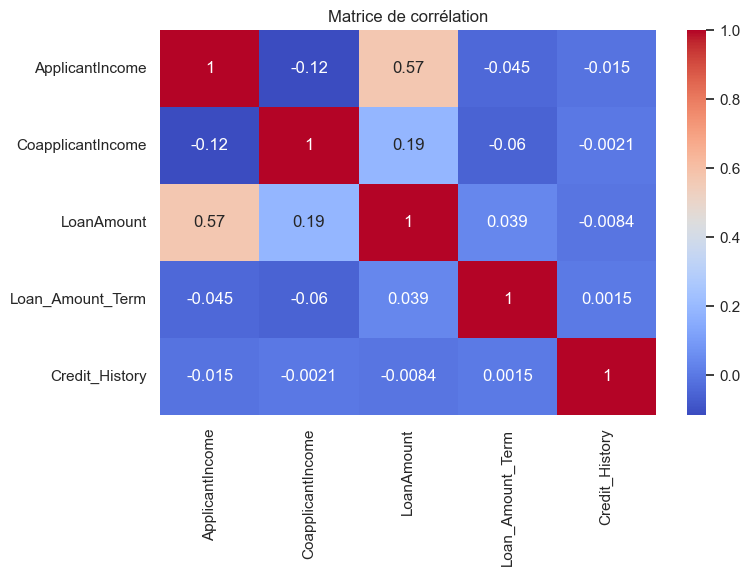

In [42]:
# ============================================
# 8. Corrélation des variables numériques
# ============================================
plt.figure(figsize=(8,5))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

La matrice de corrélation montre également qu’ApplicantIncome et LoanAmount présentent une relation modérée, tandis que les autres variables numériques présentent peu de corrélation entre elles.

## 3. Prétraitement des données et séparation train/test


In [43]:

# ============================================
# 1. Séparation features / cible
# ============================================

# Cible binaire : 1 si prêt approuvé, 0 sinon
y = (df["Loan_Status"] == "Y").astype(int)

# On enlève l'ID et la cible des features
X = df.drop(columns=["Loan_ID", "Loan_Status"])

# ============================================
# 2. Définition des colonnes numériques / catégorielles
# ============================================
numeric_features = ["ApplicantIncome", "CoapplicantIncome",
                    "LoanAmount", "Loan_Amount_Term"]

categorical_features = ["Gender", "Married", "Dependents",
                        "Education", "Self_Employed", "Property_Area", "Credit_History"]

# ============================================
# 3. Transformers pour chaque type de variable
# ============================================

# Numériques : imputation médiane + standardisation
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# Catégorielles : imputation valeur la plus fréquente + One-Hot Encoding
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]
)

# ============================================
# 4. ColumnTransformer qui applique le bon traitement à chaque groupe
# ============================================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# ============================================
# 5. Split train / test
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("X_train :", X_train, X_train.shape)
print("X_test  :", X_test, X_test.shape)



X_train :     Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
1     Male     Yes          1      Graduate            No             4583   
394   Male     Yes          2      Graduate            No             3100   
316   Male     Yes          2      Graduate            No             3717   
62    Male     Yes          0  Not Graduate           Yes             2609   
158   Male      No          0      Graduate           NaN             2980   
..     ...     ...        ...           ...           ...              ...   
311   Male      No          0  Not Graduate            No             2927   
321   Male     Yes         3+      Graduate            No             4342   
327   Male     Yes          0      Graduate           Yes             5818   
506   Male     Yes          0      Graduate            No            20833   
27    Male     Yes          2  Not Graduate            No             4226   

     CoapplicantIncome  LoanAmount  Loan_Amount_Term 

## 4. Modélisation supervisée et comparaison des modèles


Dans cette section, nous comparons plusieurs modèles de classification
(Régression Logistique, SVM linéaire et RBF, Random Forest et MLP)
en utilisant une validation croisée stratifiée (5 folds) et les métriques :
Accuracy, F1-score, ROC-AUC, Précision et Rappel.

          model          acc           f1          roc         prec  \
0        LogReg  0.787±0.028  0.863±0.017  0.721±0.038  0.775±0.026   
1    SVM-linear  0.793±0.026  0.867±0.015  0.695±0.039  0.778±0.024   
2       SVM-rbf  0.754±0.018  0.836±0.011  0.705±0.041  0.771±0.020   
3  RandomForest  0.761±0.031  0.841±0.019  0.777±0.043  0.776±0.028   
4           MLP  0.676±0.008  0.807±0.006  0.544±0.071  0.684±0.004   

           rec  
0  0.975±0.013  
1  0.981±0.006  
2  0.915±0.026  
3  0.918±0.018  
4  0.984±0.014  

Meilleur modèle (ROC-AUC CV) : RandomForest

=== Scores sur le test ===
Accuracy : 0.8311688311688312
F1       : 0.8839285714285714
ROC-AUC  : 0.8195754716981133
Precision: 0.8389830508474576
Recall   : 0.9339622641509434
Matrice de confusion :
 [[29 19]
 [ 7 99]]


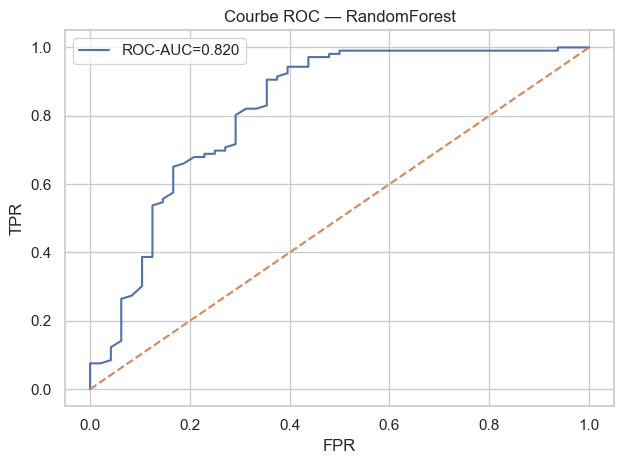

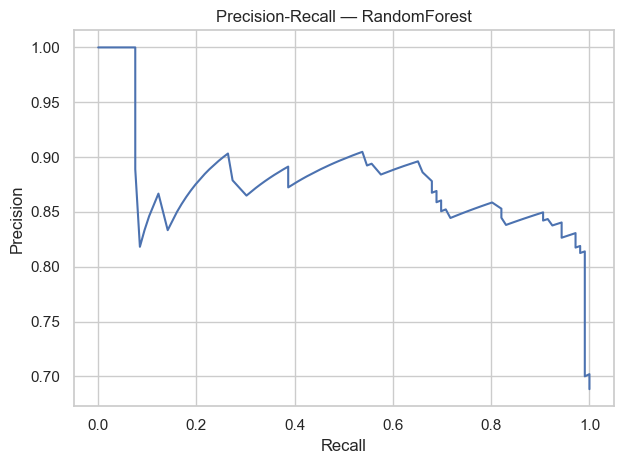

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             precision_score, recall_score, confusion_matrix,
                             roc_curve, precision_recall_curve)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

models = {
    "LogReg": Pipeline([("prep", preprocessor),
                        ("clf", LogisticRegression(C=1.0, max_iter=500, random_state=42))]),

    "SVM-linear": Pipeline([("prep", preprocessor),
                            ("clf", SVC(kernel="linear", C=10, probability=True, random_state=42))]),

    "SVM-rbf": Pipeline([("prep", preprocessor),
                         ("clf", SVC(kernel="rbf", C=10, gamma="scale", probability=True, random_state=42))]),

    "RandomForest": Pipeline([("prep", preprocessor),
                              ("clf", RandomForestClassifier(n_estimators=300,
                                                            random_state=42,
                                                            class_weight="balanced"))]),

    "MLP": Pipeline([("prep", preprocessor),
                     ("clf", MLPClassifier(hidden_layer_sizes=(32,16),
                                           activation="relu",
                                           alpha=1e-3,
                                           early_stopping=True,
                                           max_iter=1000,
                                           random_state=42))]),
}

scoring = {"acc":"accuracy","f1":"f1","roc":"roc_auc","prec":"precision","rec":"recall"}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for name, clf in models.items():
    res = cross_validate(clf, X_train, y_train,
                         cv=cv, scoring=scoring, n_jobs=-1,
                         return_train_score=False)
    rows.append({
        "model": name,
        **{m: (res[f"test_{m}"].mean(), res[f"test_{m}"].std()) for m in scoring}
    })

df_cv = pd.DataFrame(rows)
def fmt(t): return f"{t[0]:.3f}±{t[1]:.3f}"
print(df_cv.assign(**{m: df_cv[m].map(fmt) for m in scoring})[["model","acc","f1","roc","prec","rec"]])

best_row = max(rows, key=lambda r: r["roc"][0])
best_name = best_row["model"]
print("\nMeilleur modèle (ROC-AUC CV) :", best_name)

best_model = models[best_name].fit(X_train, y_train)
proba = best_model.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

print("\n=== Scores sur le test ===")
print("Accuracy :", accuracy_score(y_test, pred))
print("F1       :", f1_score(y_test, pred))
print("ROC-AUC  :", roc_auc_score(y_test, proba))
print("Precision:", precision_score(y_test, pred))
print("Recall   :", recall_score(y_test, pred))
print("Matrice de confusion :\n", confusion_matrix(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc_score(y_test, proba):.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"Courbe ROC — {best_name}")
plt.legend()
plt.tight_layout()
plt.show()

prec, rec, _ = precision_recall_curve(y_test, proba)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall — {best_name}")
plt.tight_layout()
plt.show()


Nous avons comparé plusieurs modèles de classification (Régression Logistique, SVM linéaire et RBF, Random Forest et MLP) à l’aide d’une validation croisée stratifiée à 5 folds et de plusieurs métriques (Accuracy, F1, ROC-AUC, Précision, Rappel).
Le Random Forest présente la meilleure performance en termes de ROC-AUC en validation croisée (0.78 ± 0.04) et obtient, sur le jeu de test, une accuracy de 0.83, un F1-score de 0.88 et une AUC de 0.82.
Le modèle atteint un rappel élevé (0.93) pour les dossiers approuvés, ce qui signifie qu’il identifie la plupart des bons candidats au crédit, au prix d’un certain nombre de faux positifs (19 dossiers prédits comme approuvés mais réellement refusés

## 5. Interprétation du modèle final (Random Forest)

Le Random Forest est le modèle qui obtient la meilleure performance en
termes de ROC-AUC en validation croisée et sur le jeu de test.  
Nous cherchons maintenant à **interpréter ce modèle**, c’est-à-dire à
comprendre quelles variables influencent le plus la décision d’accorder
ou non un prêt.

Pour cela, nous utilisons l’**importance par permutation** sur le jeu
de test : on mesure la baisse de performance du modèle lorsqu’on
perturbe aléatoirement chaque variable.


Credit_History       2.227273e-01
ApplicantIncome      3.571429e-03
Dependents           1.298701e-03
Property_Area        4.996004e-17
CoapplicantIncome    2.775558e-17
Loan_Amount_Term    -1.948052e-03
Self_Employed       -2.272727e-03
LoanAmount          -3.246753e-03
Education           -3.896104e-03
Gender              -6.168831e-03
Married             -8.441558e-03
dtype: float64


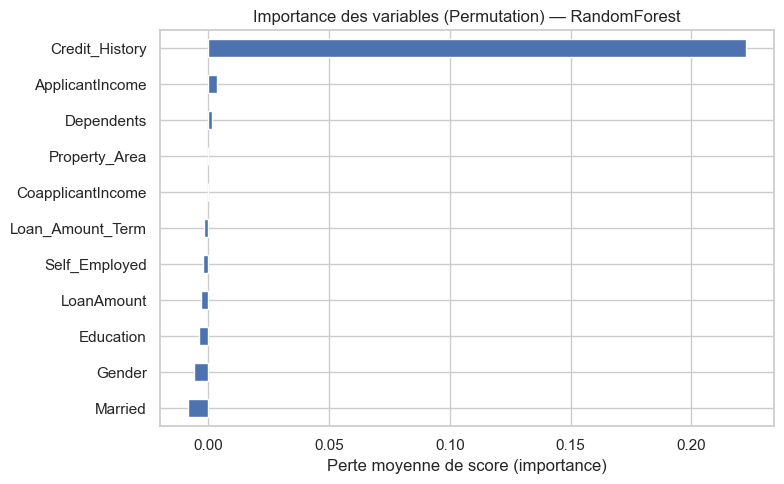

In [45]:
from sklearn.inspection import permutation_importance

r = permutation_importance(best_model, X_test, y_test,
                           n_repeats=20, random_state=42, n_jobs=-1)

# utiliser les features d'origine
feat_names = X_test.columns

importances = pd.Series(r.importances_mean, index=feat_names).sort_values(ascending=False)

print(importances.head(15))

plt.figure(figsize=(8,5))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importance des variables (Permutation) — RandomForest")
plt.xlabel("Perte moyenne de score (importance)")
plt.tight_layout()
plt.show()


L’analyse d’importance par permutation met en évidence que la variable Credit_History est de très loin la plus déterminante pour la prédiction de l’éligibilité au prêt.
Lorsque l’on perturbe cette variable, la performance du modèle (mesurée par l’AUC) chute d’environ 0,22, alors que la perturbation des autres variables n’a qu’un impact marginal, proche de zéro.

Les variables ApplicantIncome et, dans une moindre mesure, Dependents apportent un léger gain d’information, mais elles restent très secondaires par rapport à l’historique de crédit. Les autres caractéristiques (montant du prêt, durée, statut marital, genre, etc.) ont une importance moyenne proche de zéro, ce qui suggère qu’elles sont beaucoup moins exploitées par le modèle Random Forest dans ce dataset.

En résumé, le modèle apprend essentiellement que l’historique de crédit est le critère principal de décision, ce qui est cohérent avec la logique métier d’une banque : un client ayant déjà remboursé correctement ses crédits a une probabilité beaucoup plus élevée de voir son nouveau prêt accepté.

## 6. Analyse non supervisée : visualisation par PCA

Jusqu’ici, nous avons travaillé en **apprentissage supervisé** : les modèles
sont entraînés à partir de la variable cible `Loan_Status` pour prédire
l’éligibilité au prêt.

Nous réalisons maintenant une **courte analyse non supervisée** afin de
mieux comprendre la structure globale des données, indépendamment de la
cible :

- nous appliquons une **PCA (Analyse en Composantes Principales)** sur les
  variables prétraitées, pour projeter les observations dans un plan 2D ;
- nous colorons ensuite les points selon `Loan_Status`.

L’objectif n’est pas d’entraîner un nouveau modèle, mais de voir si les
données présentent une séparation naturelle entre dossiers approuvés et
refusés, ou si les deux classes sont fortement mélangées dans l’espace des
caractéristiques.


Variance expliquée par PC1 et PC2 : [0.15193256 0.1097546 ]


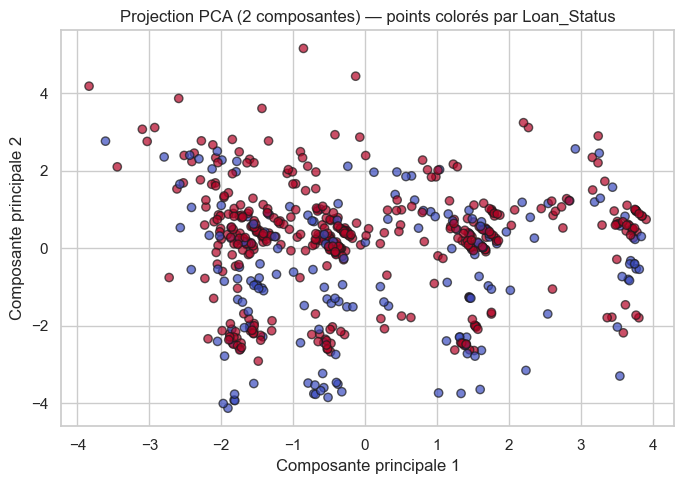

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1) On réutilise le même préprocesseur que pour les modèles
#    (imputation + encodage + scaling)
X_prep = preprocessor.fit_transform(X)

# 2) Standardisation globale avant PCA (optionnel mais propre)
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X_prep)

# 3) PCA à 2 composantes
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Variance expliquée par PC1 et PC2 :", pca.explained_variance_ratio_)

# 4) Visualisation en 2D, colorée par Loan_Status
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=y, cmap="coolwarm", edgecolor="k", alpha=0.7)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Projection PCA (2 composantes) — points colorés par Loan_Status")
plt.tight_layout()
plt.show()


Afin de compléter l’analyse par une approche non supervisée, nous avons appliqué une Analyse en Composantes Principales (PCA) sur l’ensemble des variables prétraitées, puis projeté les individus sur les deux premières composantes principales.
Celles-ci expliquent respectivement 15,2 % et 11,0 % de la variance, soit environ 26 % au total, ce qui indique que l’information est répartie dans un espace de dimension plus élevée.
Sur le nuage de points en 2D, les dossiers approuvés et refusés (colorés selon Loan_Status) apparaissent fortement mélangés, sans frontière linéaire évidente. Cela montre que la séparation entre les deux classes est relativement complexe et justifie l’utilisation de modèles non linéaires comme le Random Forest pour obtenir de bonnes performances de classification.

## 7. Conclusion

Le modèle RandomForest s'est avéré le plus performant, avec un ROC-AUC d’environ 0.82
et un rappel élevé pour les prêts approuvés. L’analyse d’importance des variables
montre que `Credit_History` est le facteur décisif, ce qui est cohérent avec la
logique métier d’une banque. La PCA confirme que les classes sont difficiles à
séparer linéairement en 2D, ce qui justifie l’usage de modèles non linéaires.

Plusieurs améliorations seraient possibles : affiner le réglage des
hyperparamètres, tester d'autres modèles d’ensembles (XGBoost, etc.) ou intégrer
des informations supplémentaires sur le profil des clients.
